In [1]:
# System.
import datetime

# Data manipulation.
import pandas as pd
import numpy as np

# Plotting.
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
# Matplotlib params.
mpl.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.edgecolor': 'gray',
    'axes.linewidth': 1,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'grid.linestyle': '--',
    'grid.color': 'lightgray',
    'font.size': 12,
    'legend.frameon': False,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'xtick.direction': 'out',
    'ytick.direction': 'out'
})

CYAN = "#03adfc"      
FANTA = "#ff9800" 

In [ ]:
# Load data.
p = '/Users/jakecordery/Desktop/dissertation-york/data/raw/covid_confirmed_usafacts.csv'
df = pd.read_csv(p)

# Drop incomplete data.
df = df[df['County Name'] != 'Statewide Unallocated']
df= df.drop('StateFIPS', axis=1).reset_index()

print(df.head(2))
print(len(df)) # 3142 counties.

   index  countyFIPS      County Name State  2020-01-22  2020-01-23  \
0      1        1001  Autauga County     AL           0           0   
1      2        1003  Baldwin County     AL           0           0   

   2020-01-24  2020-01-25  2020-01-26  2020-01-27  ...  2023-07-14  \
0           0           0           0           0  ...       19913   
1           0           0           0           0  ...       70521   

   2023-07-15  2023-07-16  2023-07-17  2023-07-18  2023-07-19  2023-07-20  \
0       19913       19913       19913       19913       19913       19913   
1       70521       70521       70521       70521       70521       70521   

   2023-07-21  2023-07-22  2023-07-23  
0       19913       19913       19913  
1       70521       70521       70521  

[2 rows x 1269 columns]
3142


In [20]:
print(f"Columns in the dataframe: {list(df.columns)}")

Columns in the dataframe: ['index', 'countyFIPS', 'County Name', 'State', '2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2

In [5]:
ID_COLS = ['countyFIPS', 'County Name', 'State'] # Save these to add back in after splitting and scaling.
NUMERIC_COLS = [col for col in df.columns if col not in ID_COLS]
NUMERIC_COLS = sorted(NUMERIC_COLS, key=lambda x: pd.to_datetime(x, errors='coerce'))

# Remove the first and last 6th of the dates because they are mostly just 0s (no daily change).
# States either didn't report cases daily or stopped entirely.
num_dates = len(NUMERIC_COLS)
new_start = num_dates // 6
new_end = num_dates - new_start

NUMERIC_COLS = NUMERIC_COLS[new_start:new_end]
cols = ID_COLS + NUMERIC_COLS 
df = df[cols]

In [6]:
# Split the dataset into train, validation and test.
def split_df(df):
    # Drop nan rows in the non_date_cols.
    df = df.dropna(axis=0, subset=ID_COLS)

    date_cols = [col for col in df.columns if col not in ID_COLS]
    date_cols_sorted = sorted(date_cols, key=lambda x: pd.to_datetime(x, errors='coerce'))

    # 75:10:15 train:test split.
    total_cols = len(date_cols_sorted)
    i1, i2 = int(total_cols * 0.75), int(total_cols * 0.85)
    trcols, valcols, tscols = ID_COLS + date_cols_sorted[:i1], ID_COLS + date_cols_sorted[i1:i2], ID_COLS + date_cols_sorted[i2:]
    dftrain, dfval, dftest = df[trcols], df[valcols], df[tscols]
    return dftrain, dfval, dftest

dftrain, dfval, dftest = split_df(df)

In [7]:
def display_mean_dist(ax, df, title):
    df_plot = df.drop(ID_COLS, axis=1)
    meandf = df_plot.mean(axis=0)
    data = meandf.to_numpy()
    
    ax.plot(np.arange(0, data.shape[0], 1), data, color=CYAN, linewidth=0.5)
    ax.set_xlabel('Date')
    ax.set_ylabel('Case Number')
    ax.set_title(title)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='lightgray')
    ax.tick_params(direction='out', length=6, width=1, colors='gray')
    return ax

In [ ]:
def make_daily(df):
    # Extract cumulative counts as a numpy array.
    cumulative_counts = df[NUMERIC_COLS].values

    # Compute daily differences along each row (county).
    daily_diff = np.diff(cumulative_counts, axis=1)  # One fewer column than cumulative.
    daily_cases = daily_diff.copy()
    daily_cases[daily_cases < 0] = 0  # Ensure no negative daily cases from error.
    NUMERIC_COLS = NUMERIC_COLS[1:]

    # Create county-level daily dataframe.
    df_daily = df[ID_COLS].copy()
    df_daily = pd.concat([df_daily, pd.DataFrame(daily_cases, columns=NUMERIC_COLS)], axis=1)
    return df_daily

In [ ]:
def interpolate_df(df):
    # Transpose, interpolate (so that each date column is filled column-wise), then transpose back.
    # Interpolate missing values along the date axis for each county.
    df[NUMERIC_COLS] = df[NUMERIC_COLS]

    # Forward fill to handle leading NaNs.
    df[NUMERIC_COLS] = df[NUMERIC_COLS].interpolate(method="linear", axis=1, limit_direction='both').ffill(axis=1).bfill(axis=1)

    # Now, column wise since some are missed!
    df[NUMERIC_COLS] = df[NUMERIC_COLS].interpolate(method="nearest", axis=1).ffill(axis=0).bfill(axis=0)

    # Check to ensure no NaNs remain.
    if df[NUMERIC_COLS].isnull().values.any():
        raise ValueError("There are still missing values in the DataFrame after interpolation and filling.")
    
    # Now interpolate days where states clearly only uploaded n times a week.
    df[df[NUMERIC_COLS] == 0] = np.nan
    df[NUMERIC_COLS] = df[NUMERIC_COLS].interpolate(method="linear", axis=1).ffill(axis=0).bfill(axis=0)
    return df

In [ ]:
def display_plots(df1, df2):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    display_mean_dist(ax[0], df1, title='Before scaling')
    display_mean_dist(ax[1], df2, title='After Scaling')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def display_states(df):
    df = df.drop(columns=['countyFIPS', 'County Name'])
    df = df.groupby('State').mean().reset_index()

    # Assume df is your DataFrame and it has non-numeric columns:
    non_date_cols = ['State']
    # date_cols now holds only columns with numeric (date) values
    date_cols = [col for col in df.columns if col not in non_date_cols]

    # Determine the number of rows (counties)
    n_counties = df.shape[0]

    # Create subplots: one per county, arranged vertically
    fig, axes = plt.subplots(n_counties, 1, figsize=(12, 3 * n_counties), sharex=True)

    # If there is only one county, make sure axes is a list
    if n_counties == 1:
        axes = [axes]
        

    # Loop over each row.
    for j, (i, row) in enumerate(df.iterrows()):
        ax = axes[i]
        # Plot only the numerical (date) columns for this county
        ax.plot(np.arange(0, len(date_cols), 1), row[date_cols].values, color=CYAN, linewidth=0.5)
        # Set the title of the subplot to the county name
        ax.set_title(row['State'])

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [14]:
def scale_df(df, display_plot=True, train=False, display_states=True):
    # Translate the cumulative case numbers into daily new cases.
    df = make_daily(df)

    # Interpolate missing values along the date axis for each county.
    df = interpolate_df(df)
    df_original = df.copy()

    # Scale the data column-wise (i.e. by date) via natural logarithm.
    logscale = lambda x: np.log(x + 1e-3) # + small constant stops ln(0).

    df[NUMERIC_COLS] = df[NUMERIC_COLS].apply(logscale, axis=1)
    df_log = df.copy() # Save copy for plotting.
    

    # Scale between 0 and 1 to account for population number.
    unitscale = lambda x: (x - x.min()) / (x.max() - x.min())

    df[NUMERIC_COLS] = df[NUMERIC_COLS].apply(unitscale, axis=1)
    df_unit = df.copy() # Save copy for plotting.

    nan_count_per_column = df.isnull().sum().sum()
    print(f"Nans count in the dataframe: {nan_count_per_column}")

    if display_plot:
        display_plots(df_original, df_unit)

    if display_states:
        display_states(df)

    if display_states:
       

    return df

0


/var/folders/j9/bcpct8w966j66c8j5tg5wd4c0000gn/T/ipykernel_36201/4021558314.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


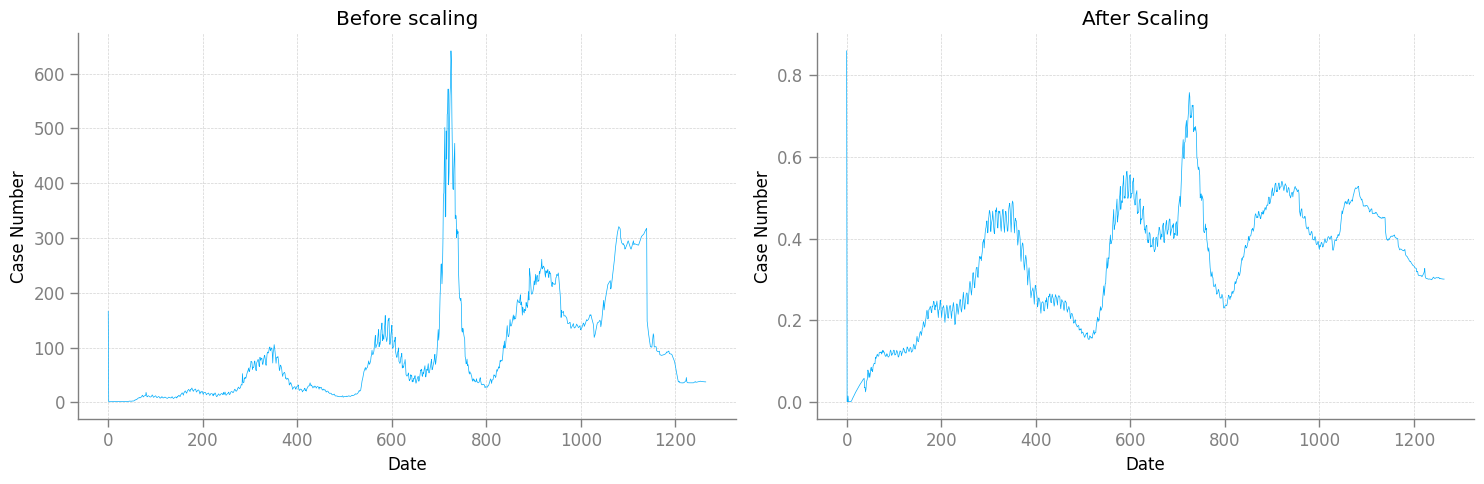

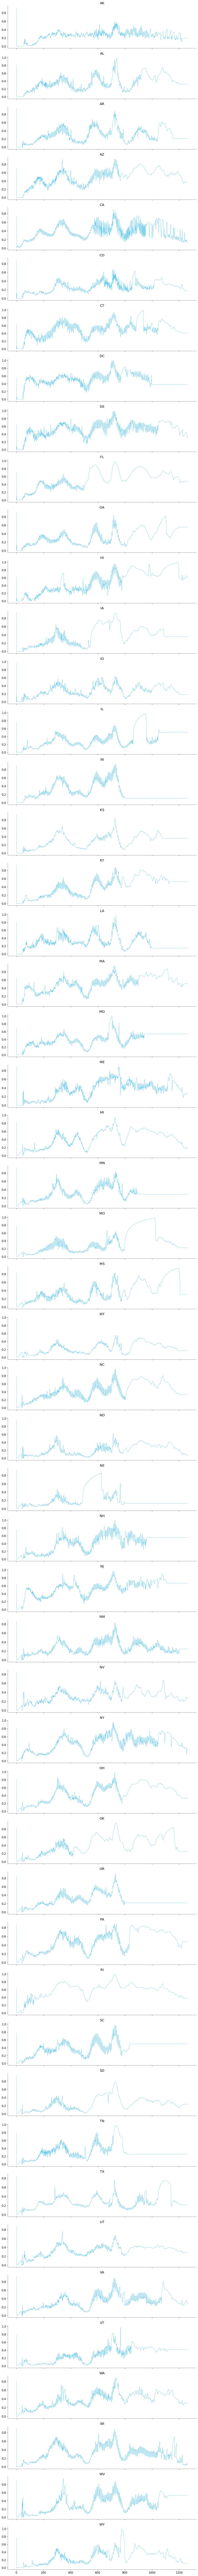

In [15]:
scaled_df = scale_df(d)


0


/var/folders/j9/bcpct8w966j66c8j5tg5wd4c0000gn/T/ipykernel_36201/4021558314.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


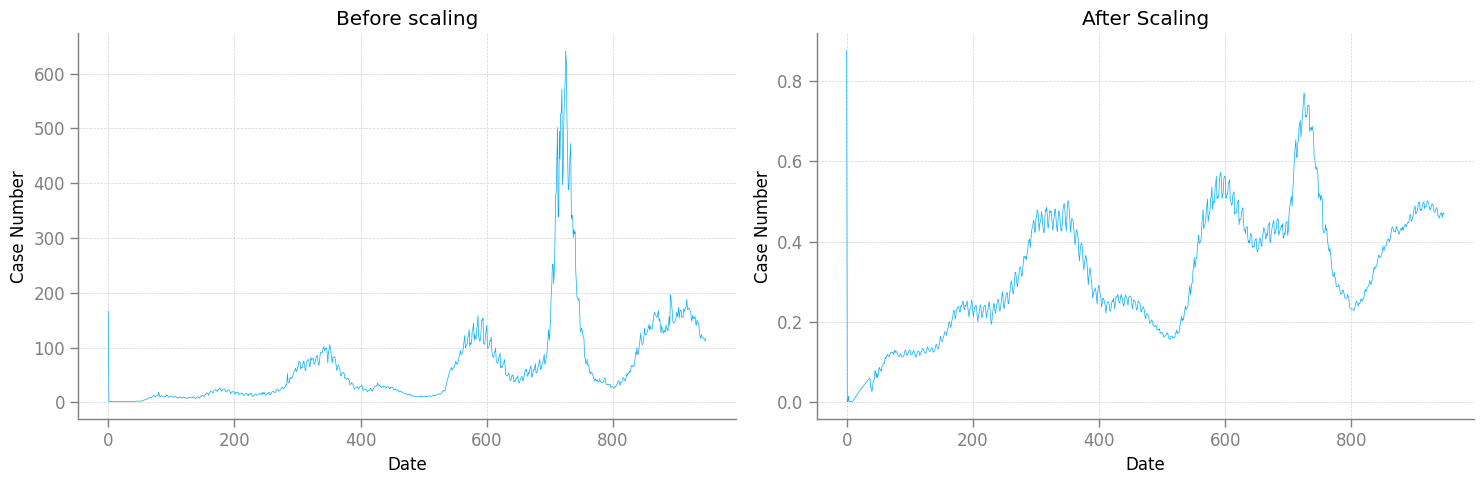

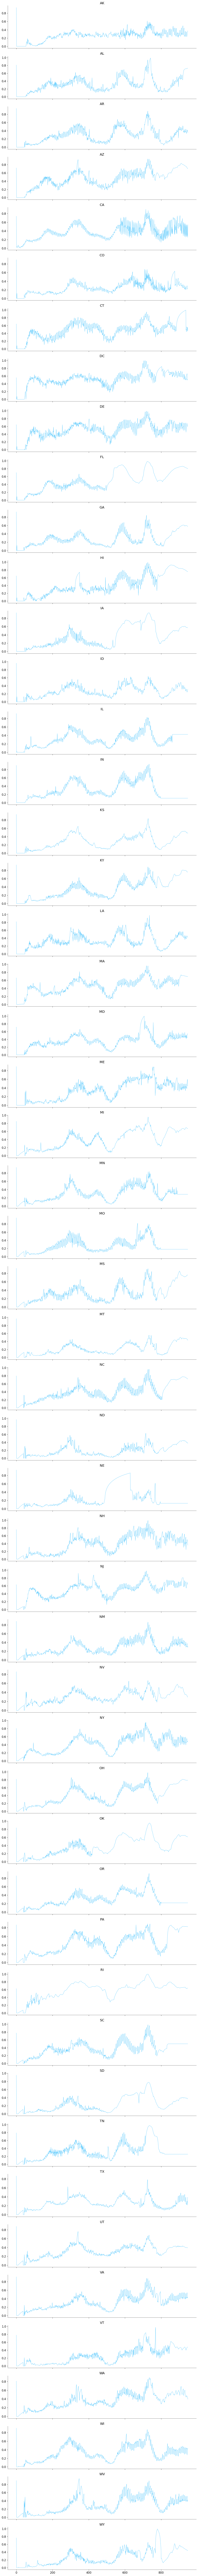

Length before dropping per state: 3142
Length after dropping per state: 3142


In [16]:
dftrain_scaled = scale_df(dftrain, train=True)
print(f"Length before dropping per state: {len(dftrain_scaled)}")
dftrain_scaled = dftrain_scaled.dropna(axis=0)
print(f"Length after dropping per state: {len(dftrain_scaled)}")
dftrain_scaled.to_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/TRAIN_SCALED.csv')

0


/var/folders/j9/bcpct8w966j66c8j5tg5wd4c0000gn/T/ipykernel_36201/4021558314.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


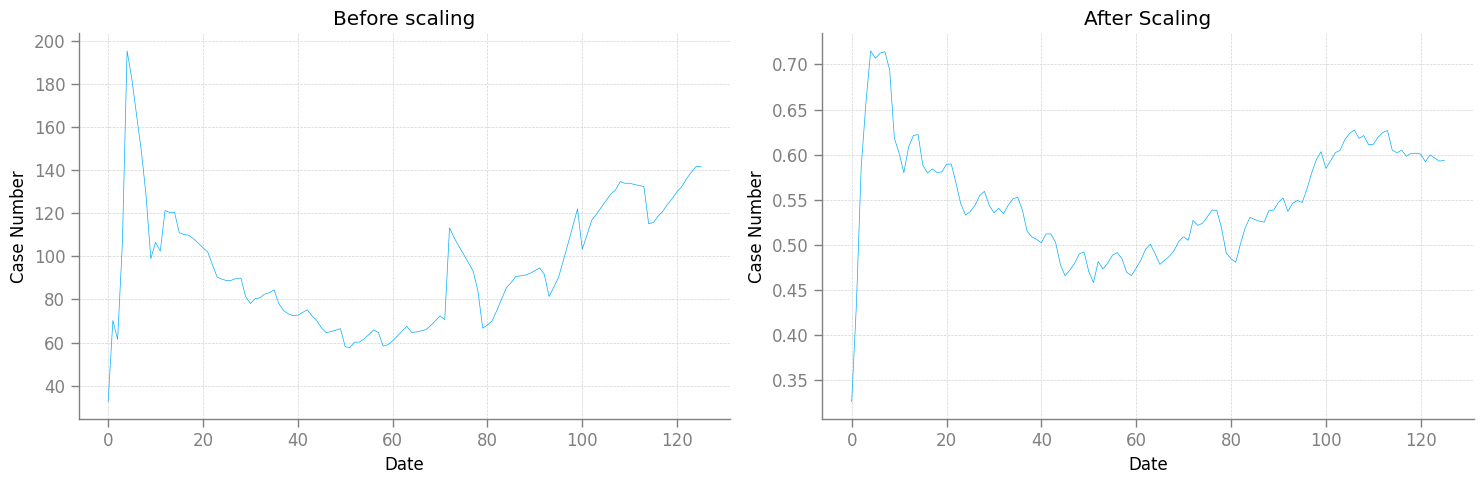

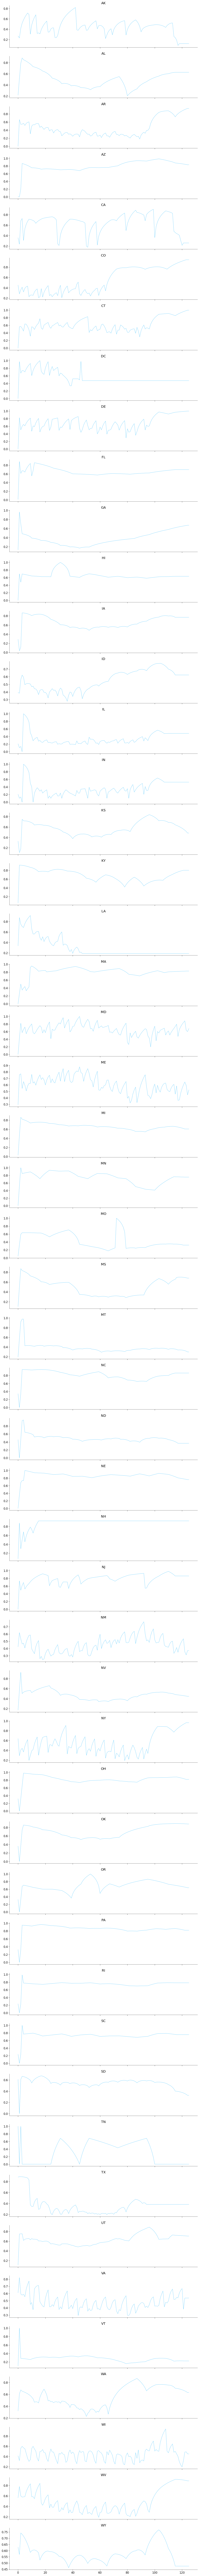

Length before dropping per state: 3142
Length after dropping per state: 3138


In [17]:
dfval_scaled = scale_df(dfval)
print(f"Length before dropping per state: {len(dfval_scaled)}")
dfval_scaled = dfval_scaled.dropna(axis=0)
print(f"Length after dropping per state: {len(dfval_scaled)}")
dfval_scaled.to_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/VAL_SCALED.csv')

3142


/var/folders/j9/bcpct8w966j66c8j5tg5wd4c0000gn/T/ipykernel_36201/4021558314.py:72: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


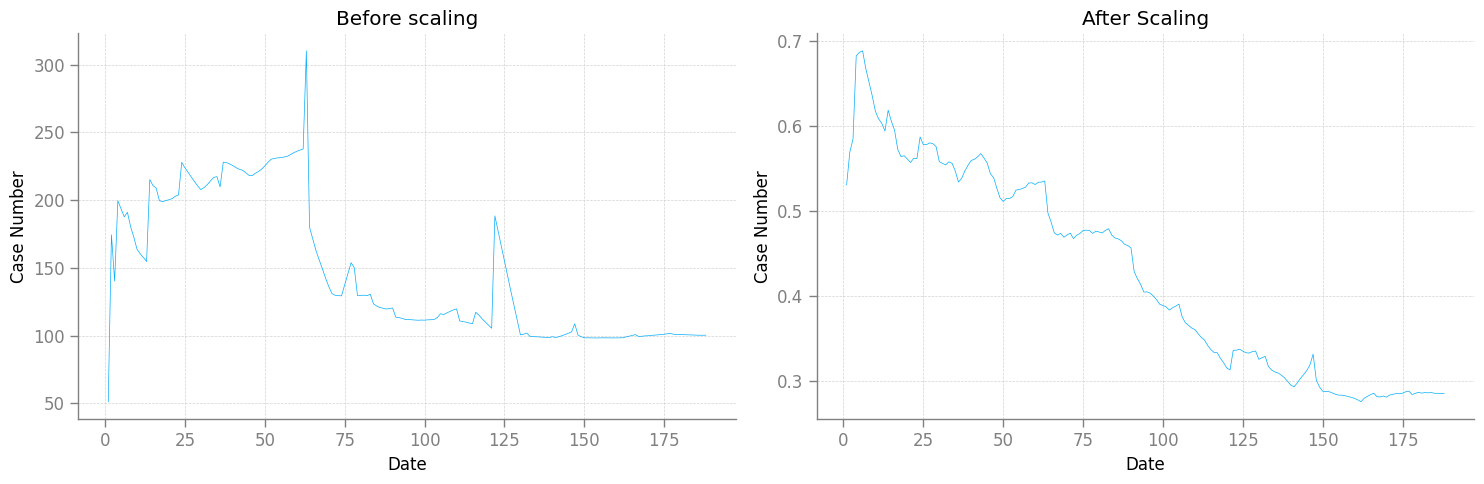

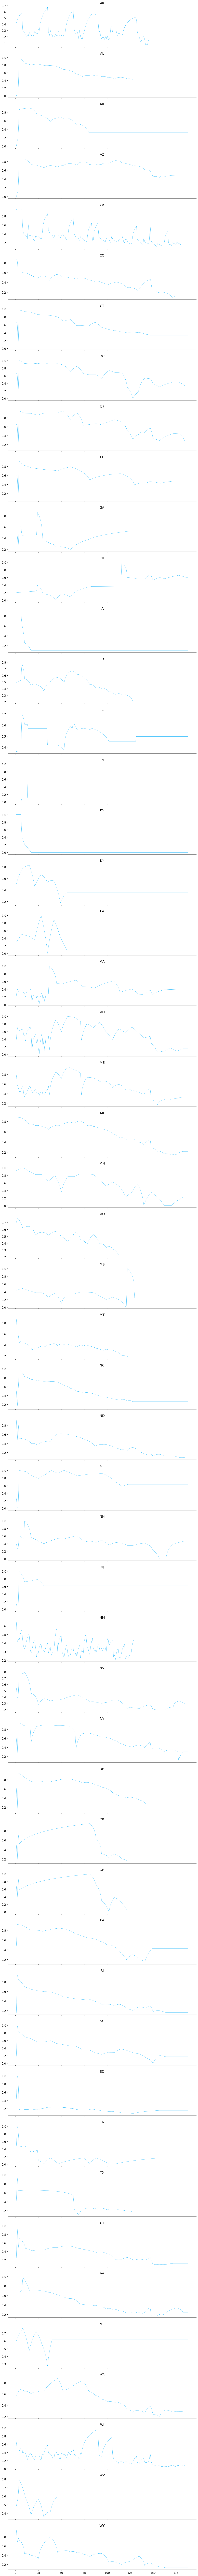

Length before dropping per state: 3142
Length after dropping per state: 0


In [18]:
dftest_scaled = scale_df(dftest)
print(f"Length before dropping per state: {len(dftest_scaled)}")
dftest_scaled = dftest_scaled.dropna(axis=0)
print(f"Length after dropping per state: {len(dftest_scaled)}")
dftest_scaled.to_csv('/Users/jakecordery/Desktop/dissertation-york/data/processed/TEST_SCALED.csv')

In [19]:
# Make a distribution of all of the means.
mean_df = df[NUMERIC_COLS].mean(axis=1)
p = sns.histplot(data=mean_df)
p = p.set_xlim(0, 100)

NameError: name 'df' is not defined

189750


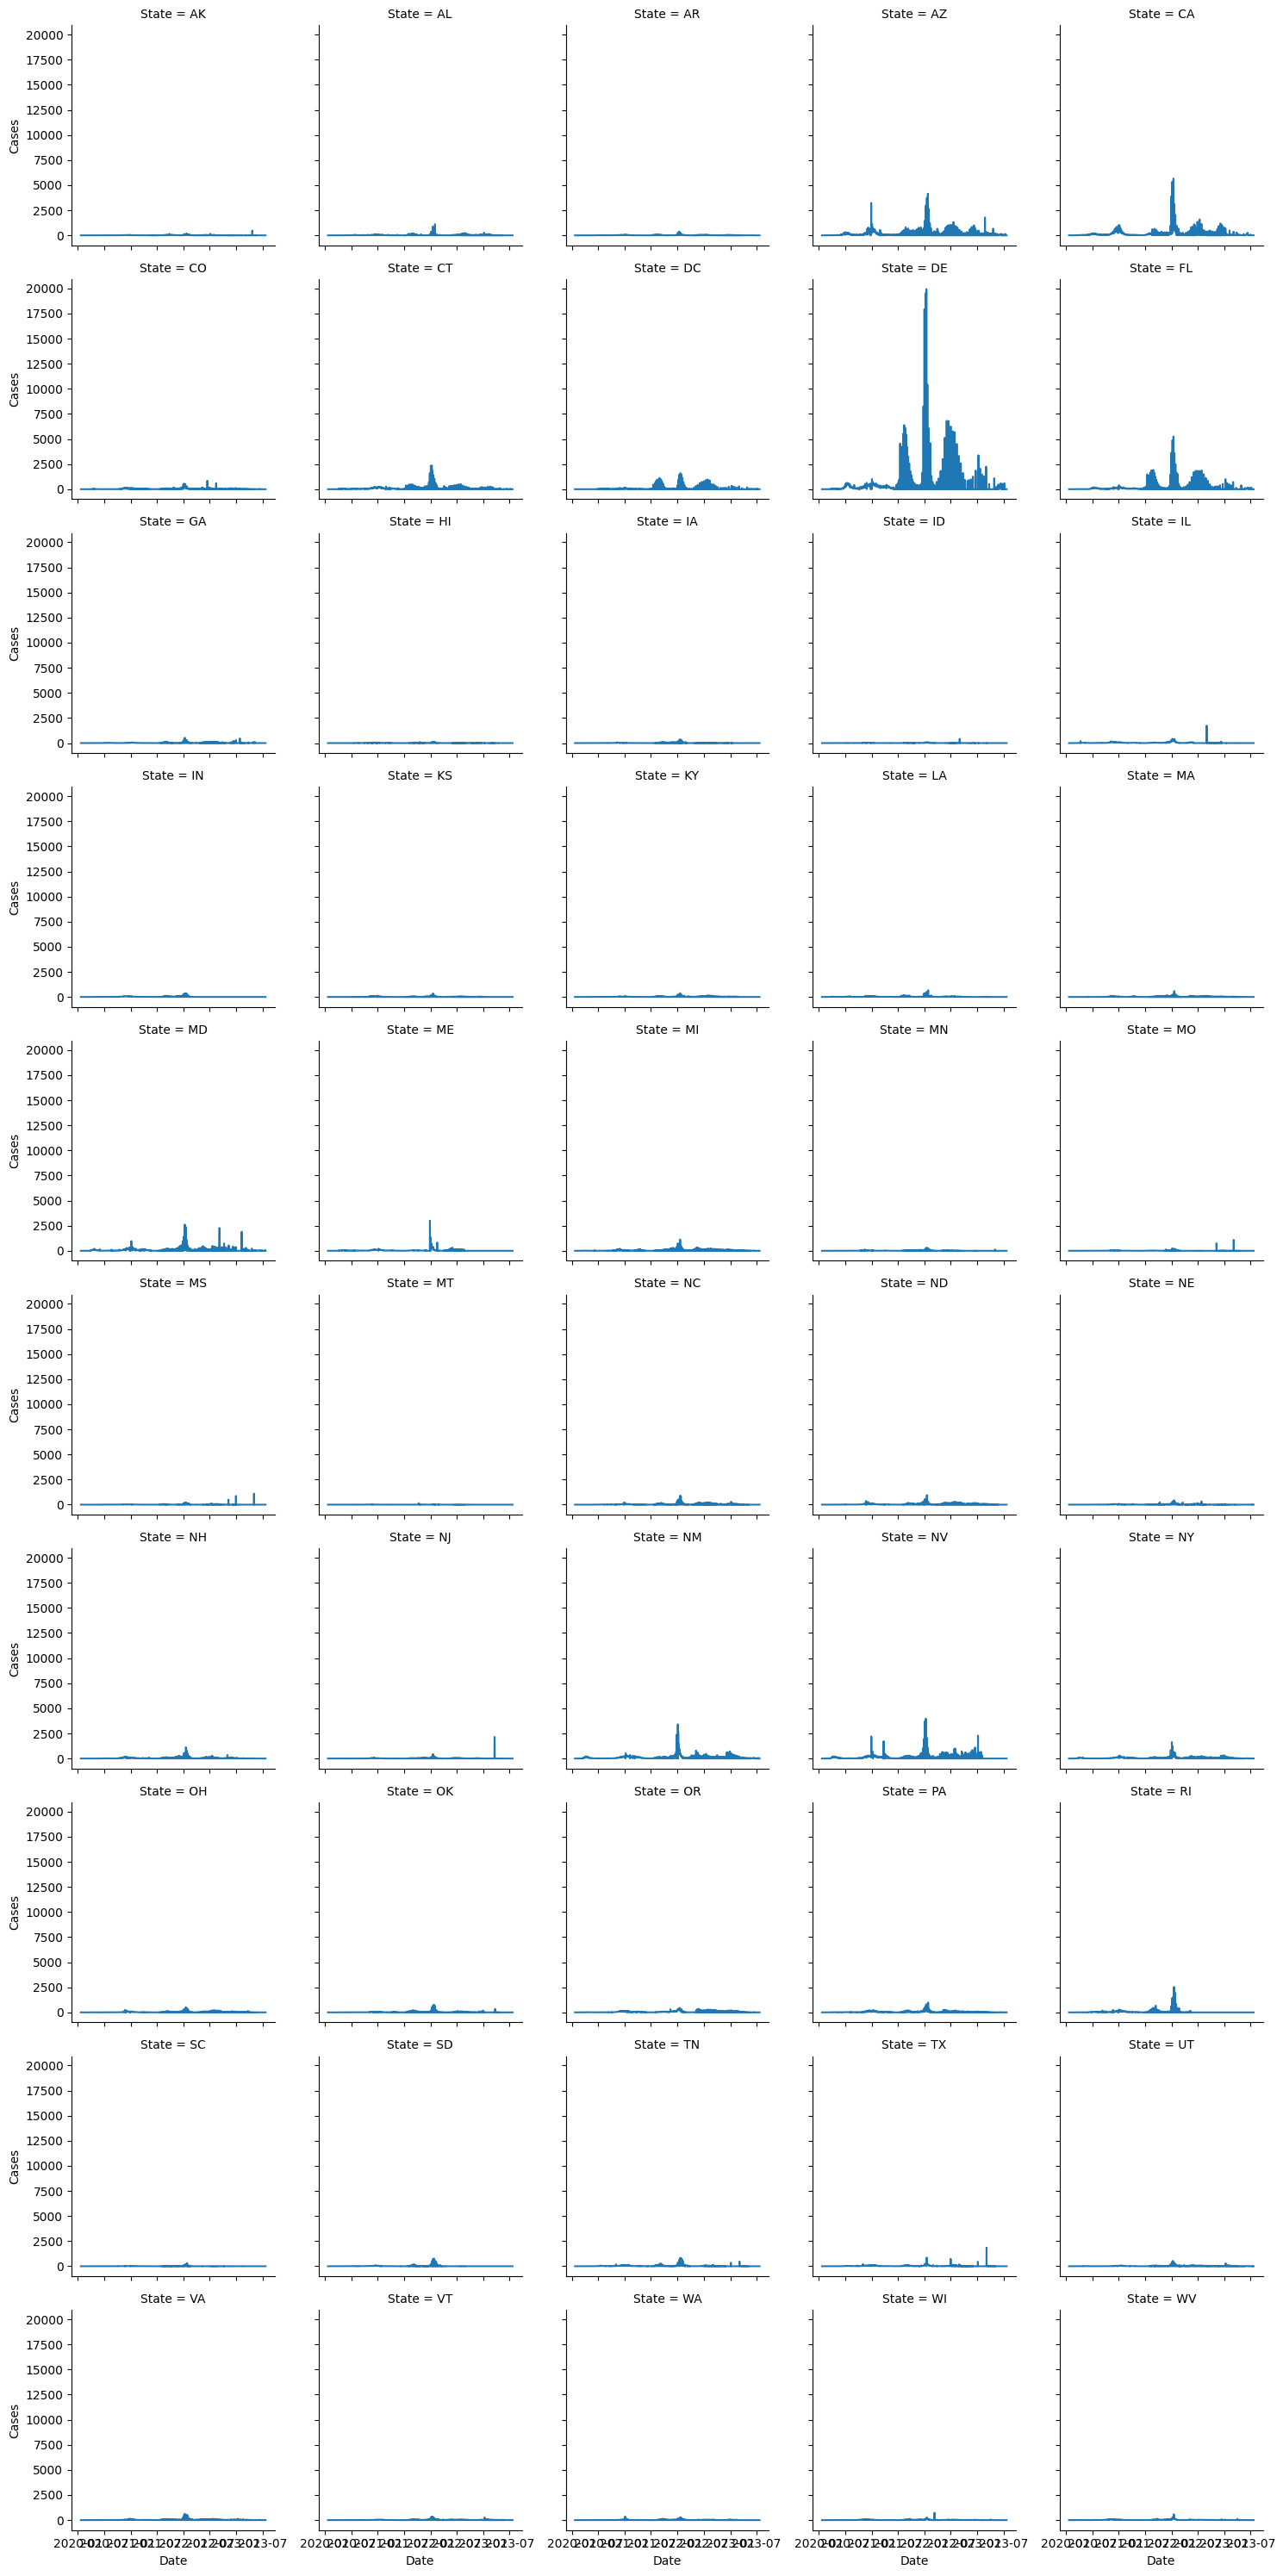

In [6]:
# Average the case numbers by state to observe a simpler view of the trends. 
cols = ['State'] + NUMERIC_COLS
state_df = df[cols].groupby('State').mean().reset_index()

# Plot each row as a lineplot.
state_df_long = pd.melt(state_df, id_vars="State", var_name="Date", value_name="Cases")
state_df_long["Date"] = pd.to_datetime(state_df_long["Date"])
print(state_df_long.size)

g = sns.FacetGrid(state_df_long, col="State", col_wrap=5, height=3)
g.map(sns.lineplot, "Date", "Cases")


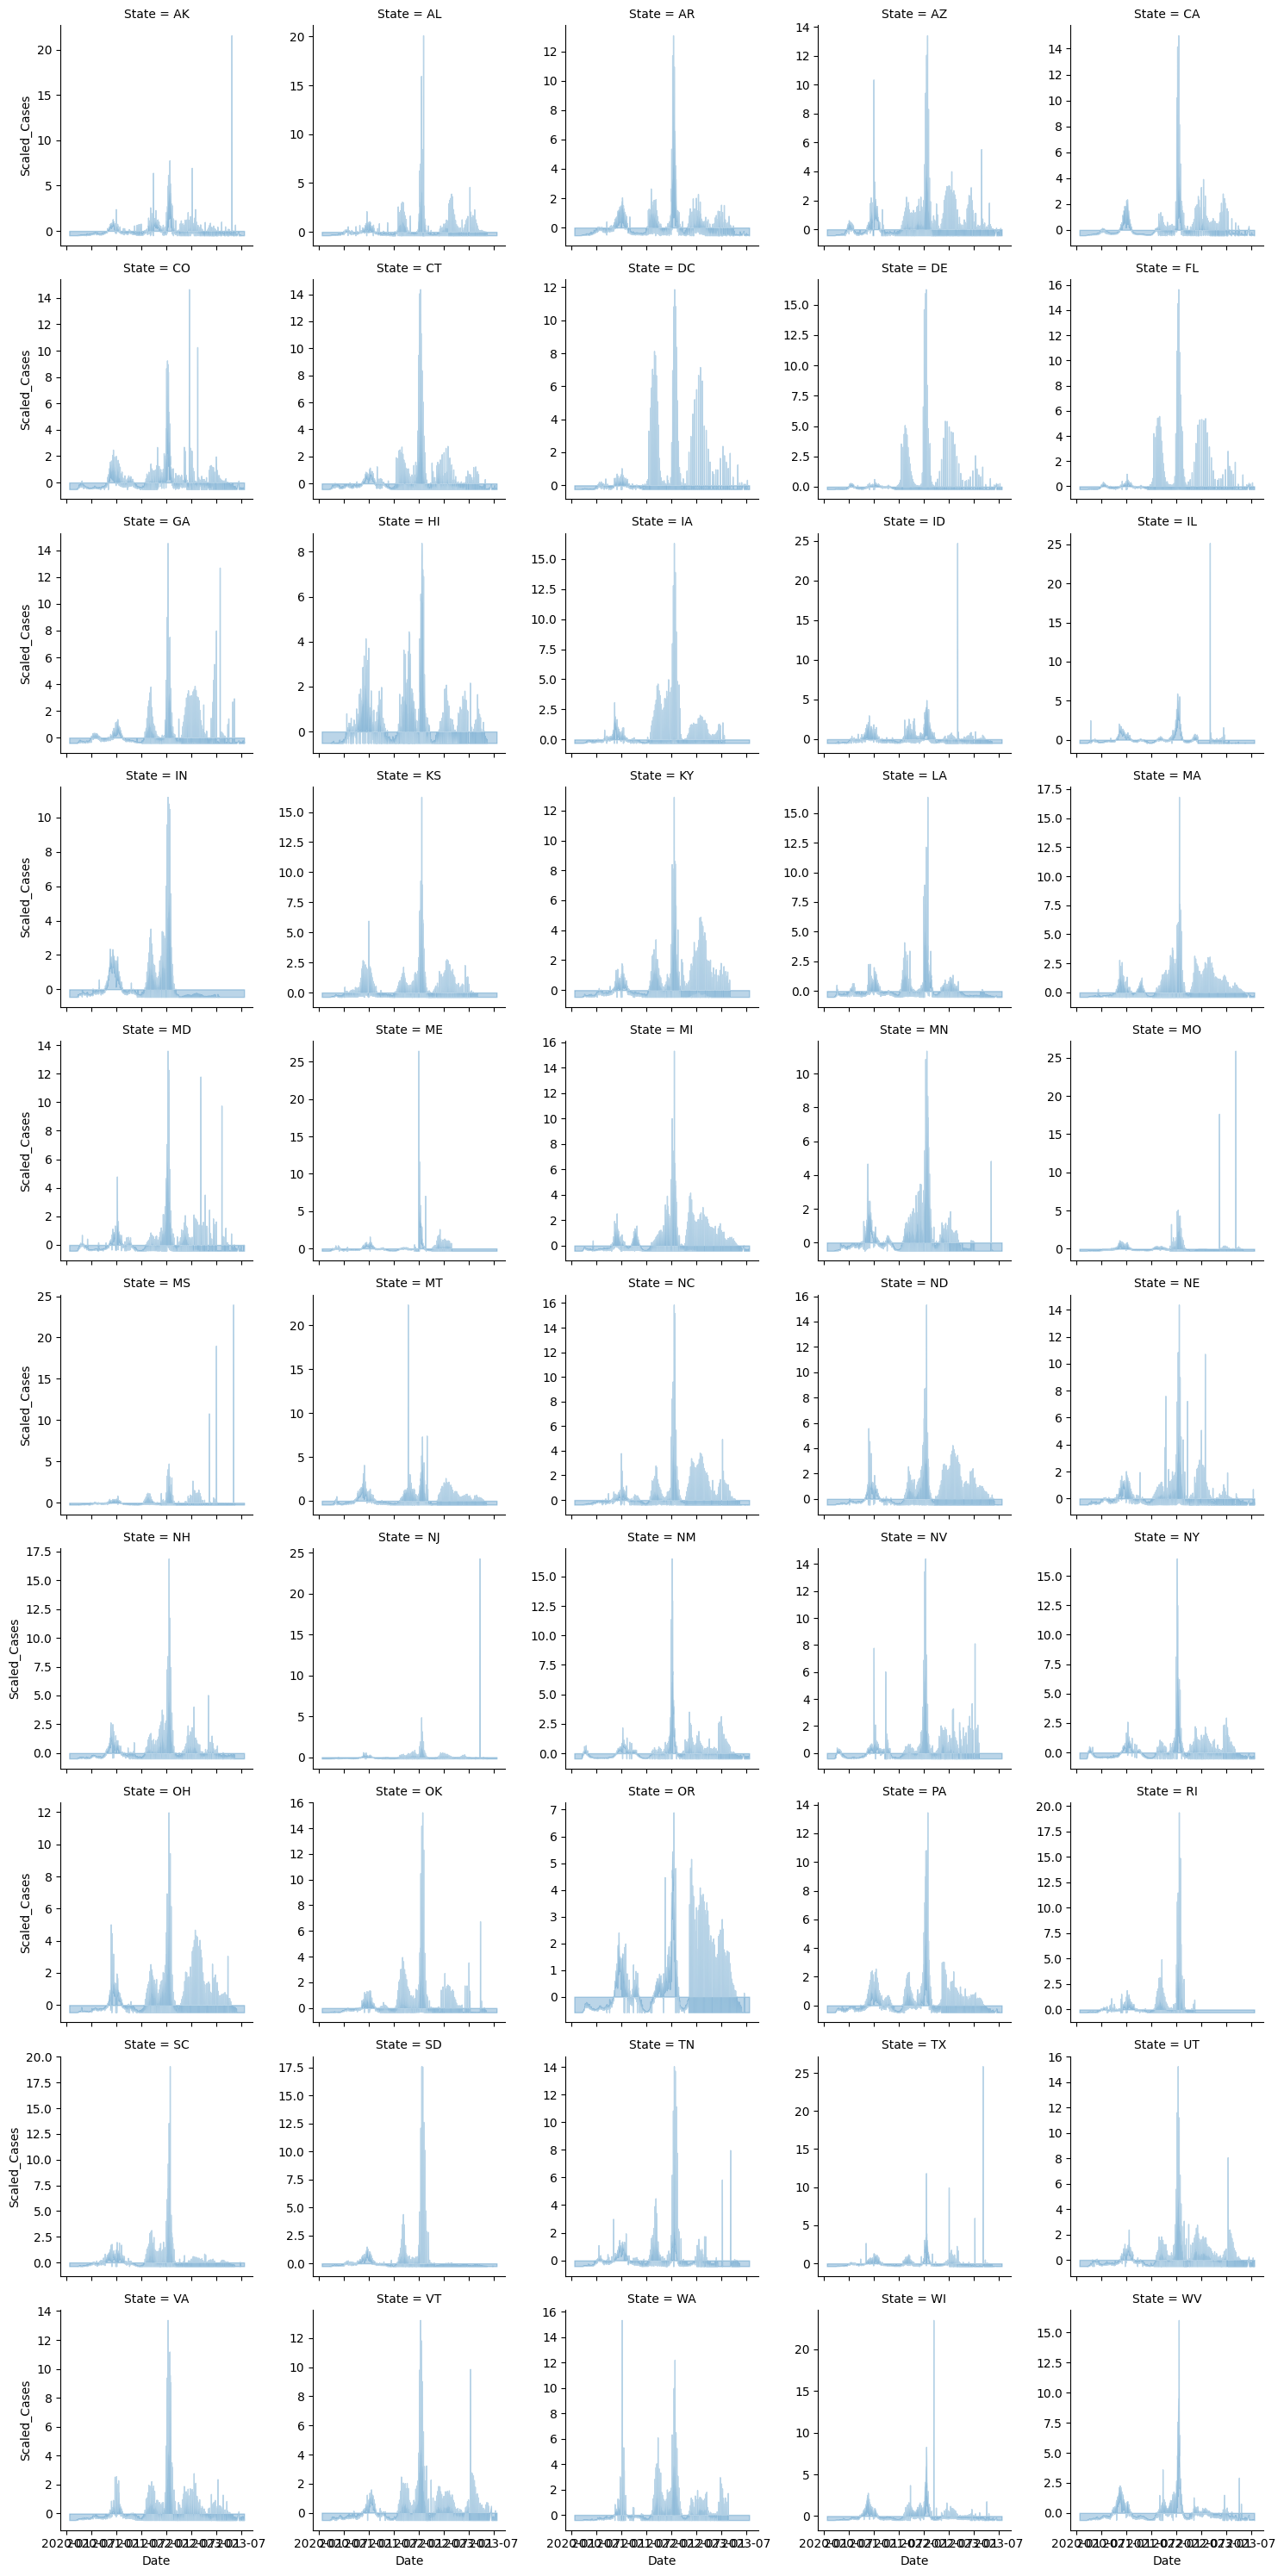

In [ ]:
# 1. Set 'State' as index and transpose so that dates become rows
state_df_wide = state_df.set_index('State').T

# Convert the index (dates) to datetime objects
state_df_wide.index = pd.to_datetime(state_df_wide.index)

def scale(x): # Scale between 1 and -1.
    return 2 * (x - x.min()) / (x.max() - x.min()) - 1

def scale(x): # Normalize.
    return (x - x.mean()) / x.std()

scaled_wide = state_df_wide.apply(scale)

# Melt to long format for plotting.
scaled_long = scaled_wide.reset_index().melt(id_vars='index', var_name='State', value_name='Scaled_Cases')
scaled_long.rename(columns={'index': 'Date'}, inplace=True)


# Adjust col_wrap (e.g., 4 columns per row) as needed
g = sns.FacetGrid(scaled_long, col="State", col_wrap=5, height=3, sharey=False) # DON'T SHARE THE SAME Y SCALE!
g.map(plt.fill_between, "Date", "Scaled_Cases", alpha=0.3)  # Fills area under curve
plt.show()


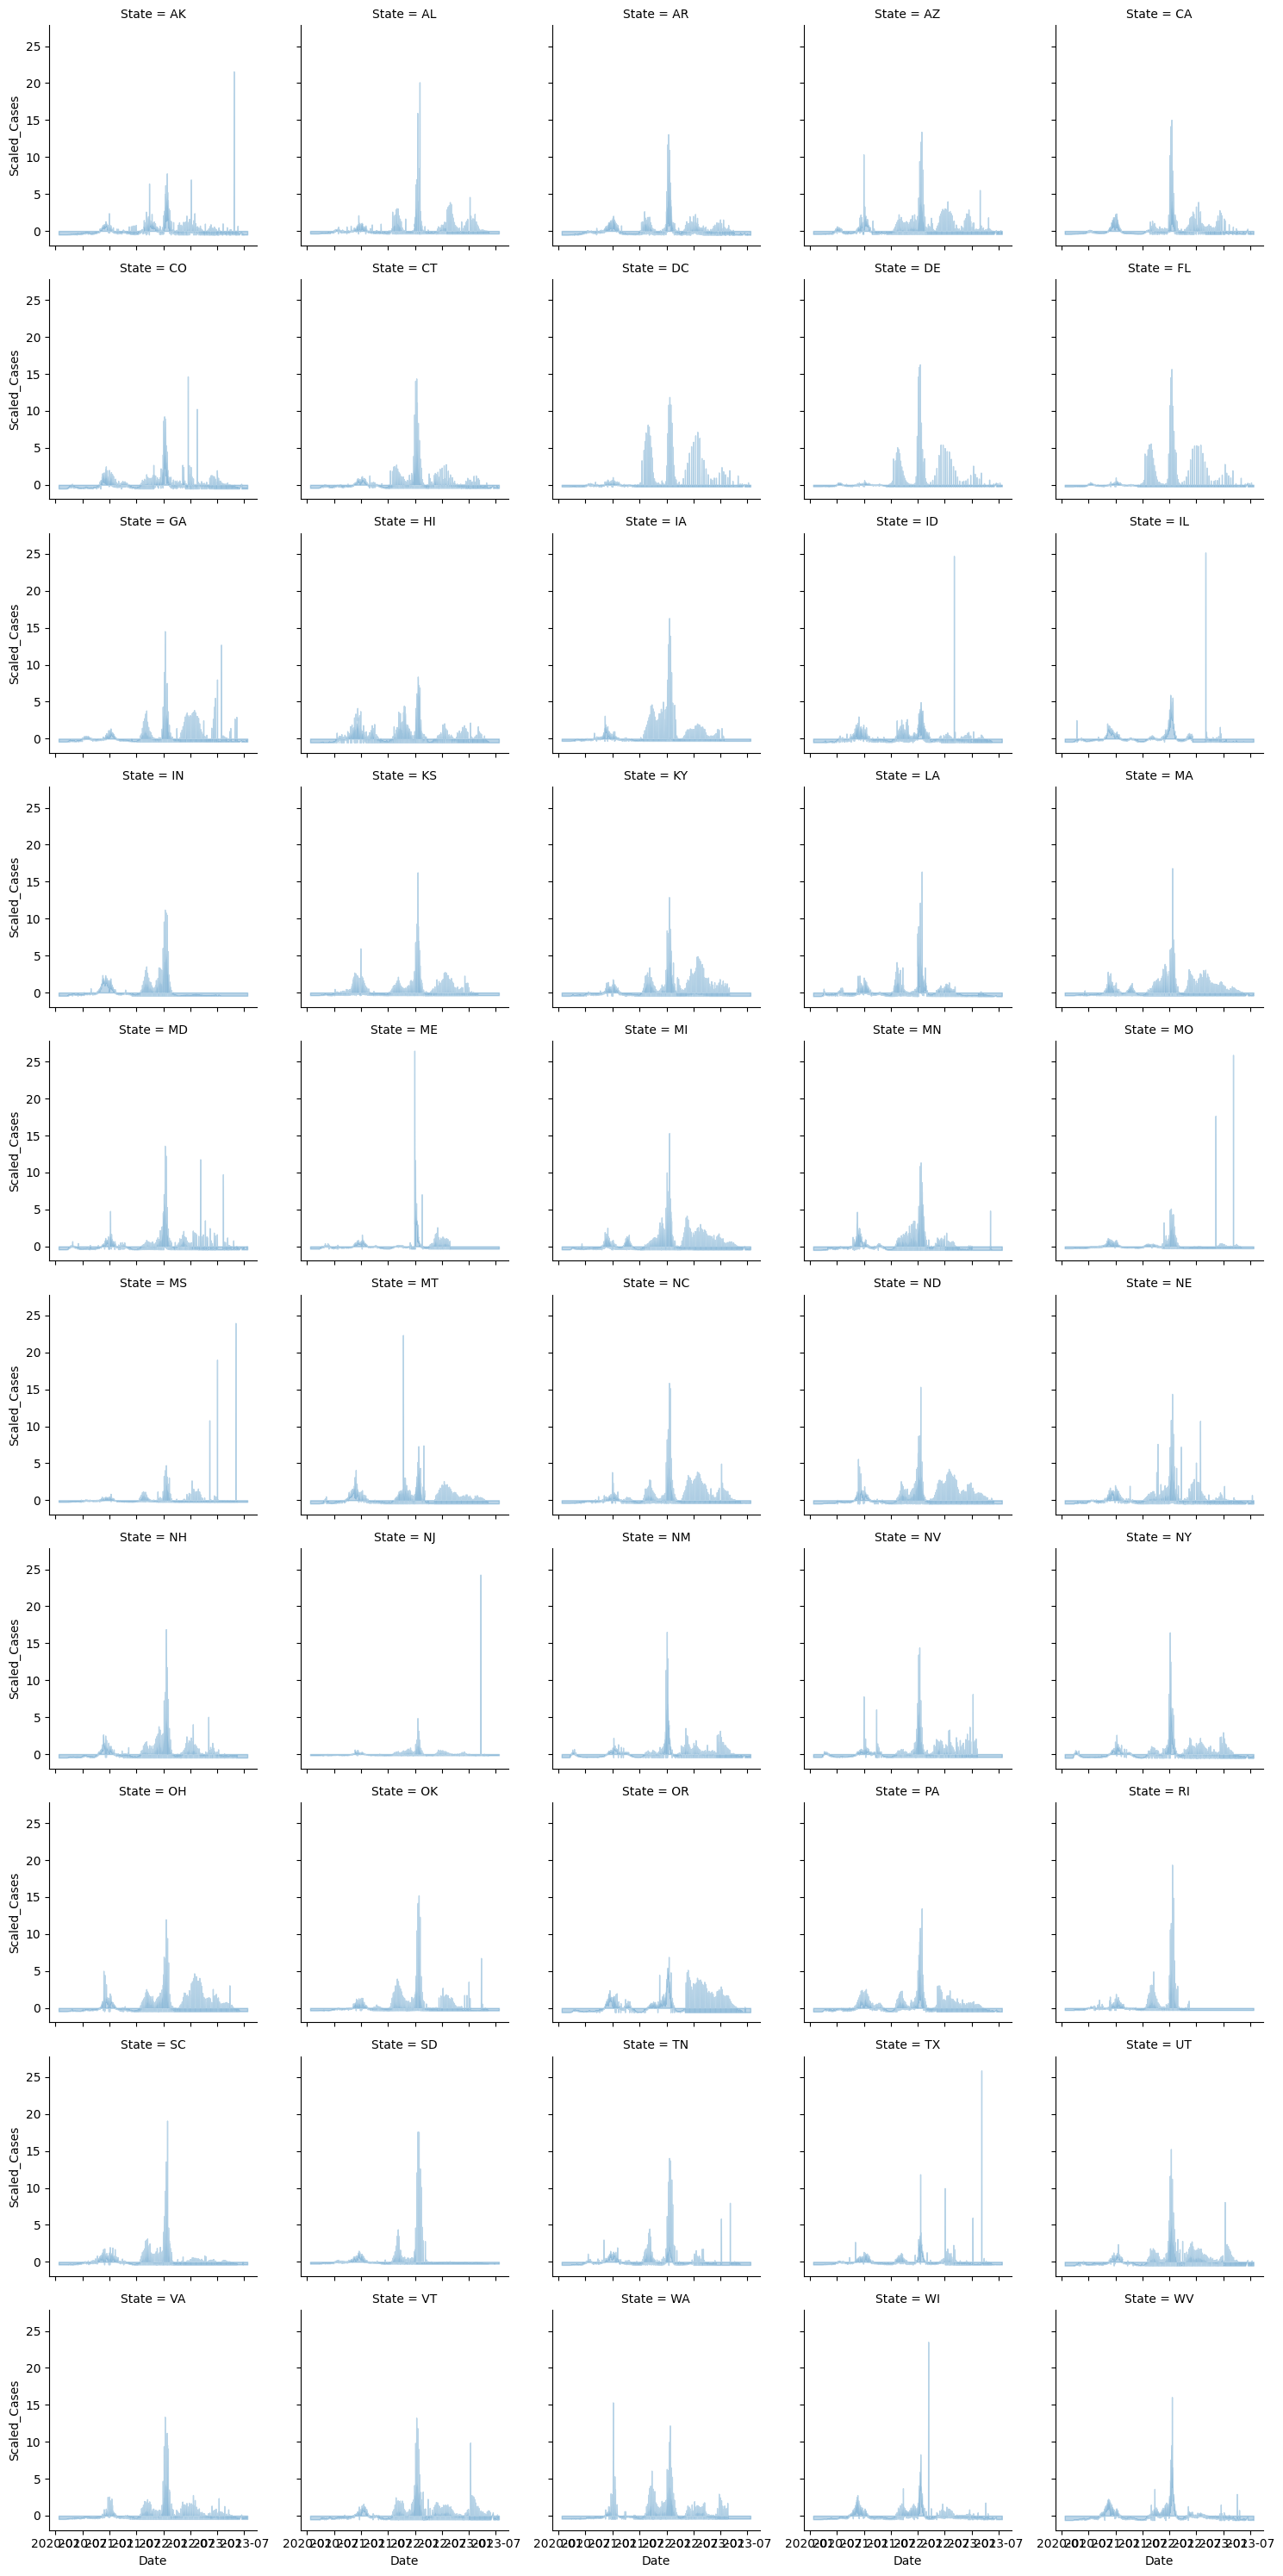

In [8]:
# Some values are missing - interpolate linearly.
scaled_long["Scaled_Cases"] = scaled_long["Scaled_Cases"].interpolate(method="linear")
g = sns.FacetGrid(scaled_long, col="State", col_wrap=5, height=3, sharey=True)
g.map(plt.fill_between, "Date", "Scaled_Cases", alpha=0.3)  # Fills area under curve.
plt.show()

In [10]:
# Save dataframe.
#scaled_long.to_csv('data/processed/SCALED_DATA.CSV')